In [3]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
from keras.utils import to_categorical
import keras.utils as image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import glob
import PIL
import random

In [2]:
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')

print(f"Mass train: {len(mass_train)}")
print(f"Mass test: {len(mass_test)}")
print(f"Calc train: {len(calc_train)}")
print(f"Calc test: {len(calc_test)}")

Mass train: 1318
Mass test: 378
Calc train: 1546
Calc test: 326


In [4]:
# Read in the dicom data CSV
dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

# Define the base image directory
image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

# Filter for different image types based on SeriesDescription
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
full_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
ROI_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path

# Replace the base directory in the image paths
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_images = full_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_images = ROI_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
dicom_data['new_image_path'] = dicom_data['image_path'].apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

# Count the number of images in each file type
num_cropped_images = len(cropped_images)
num_full_images = len(full_images)
num_roi_images = len(ROI_images)

# Display the counts
print(f"Number of Cropped Images: {num_cropped_images}")
print(f"Number of Full Mammogram Images: {num_full_images}")
print(f"Number of ROI Mask Images: {num_roi_images}")

Number of Cropped Images: 3567
Number of Full Mammogram Images: 2857
Number of ROI Mask Images: 3247


In [5]:
images_df = pd.DataFrame(ROI_images)

images_df['Modified Image Path'] = images_df['image_path'].str.replace('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/', '', regex=False)
images_df['Modified Image Path'] = images_df['Modified Image Path'].str[:-10]
images_df

,image_path,Modified Image Path
5,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.153339052913121382622...
8,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.178994714611485132105...
9,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.411833492612373627114...
14,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.236373548712994183418...
20,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.357008050412534761329...
...,...,...
10226,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.374221285124370132151...
10228,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.195242971118587811360...
10230,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.263713351013050806016...
10232,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.627982547125586065005...


In [6]:
def remove_up_to_second_slash(path):
    parts = path.split('/')
    return '/'.join(parts[2:])

In [7]:
combined_df = pd.concat([mass_train, mass_test, calc_train, calc_test], ignore_index=True)
combined_df['ROI mask file path'] = combined_df['ROI mask file path'].str[:-12]
combined_df['ROI mask file path'] = combined_df['ROI mask file path'].apply(remove_up_to_second_slash)

In [8]:
combined_df = combined_df.merge(images_df, left_on='ROI mask file path', right_on='Modified Image Path', how='left')
combined_df

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,breast density,calc type,calc distribution,image_path,Modified Image Path
0,P_00001,3.0,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,NaN,NaN,NaN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...
1,P_00001,3.0,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,1.3.6.1.4.1.9590.100.1.2.227955274711225756835...,NaN,NaN,NaN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.227955274711225756835...
2,P_00004,3.0,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,1.3.6.1.4.1.9590.100.1.2.429120414011832984817...,NaN,NaN,NaN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.429120414011832984817...
3,P_00004,3.0,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,1.3.6.1.4.1.9590.100.1.2.115134232113001553100...,NaN,NaN,NaN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.115134232113001553100...
4,P_00004,3.0,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,1.3.6.1.4.1.9590.100.1.2.128573663126257012032...,NaN,NaN,NaN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,1.3.6.1.4.1.9590.100.1.2.128573663126257012032...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3563,P_02464,NaN,RIGHT,MLO,1,calcification,NaN,NaN,0,MALIGNANT,4,Calc-Test_P_02464_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_02464_RIGHT_MLO_1/1.3.6.1.4.1.9590...,1.3.6.1.4.1.9590.100.1.2.526198631111753026131...,2.0,FINE_LINEAR_BRANCHING,CLUSTERED,NaN,NaN
3564,P_02498,NaN,RIGHT,CC,1,calcification,NaN,NaN,0,BENIGN,3,Calc-Test_P_02498_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_02498_RIGHT_CC_1/1.3.6.1.4.1.9590....,1.3.6.1.4.1.9590.100.1.2.355286671810515664909...,4.0,PUNCTATE,CLUSTERED,NaN,NaN
3565,P_02498,NaN,RIGHT,MLO,1,calcification,NaN,NaN,0,BENIGN,3,Calc-Test_P_02498_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_02498_RIGHT_MLO_1/1.3.6.1.4.1.9590...,1.3.6.1.4.1.9590.100.1.2.366216590611306753640...,4.0,PUNCTATE,CLUSTERED,NaN,NaN
3566,P_02501,NaN,RIGHT,CC,1,calcification,NaN,NaN,0,MALIGNANT,3,Calc-Test_P_02501_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_02501_RIGHT_CC_1/1.3.6.1.4.1.9590....,1.3.6.1.4.1.9590.100.1.2.275923704411531002833...,3.0,PLEOMORPHIC,CLUSTERED,NaN,NaN


2191    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2192    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2266    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2267    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2526    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
4506    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
Name: new_image_path, dtype: object


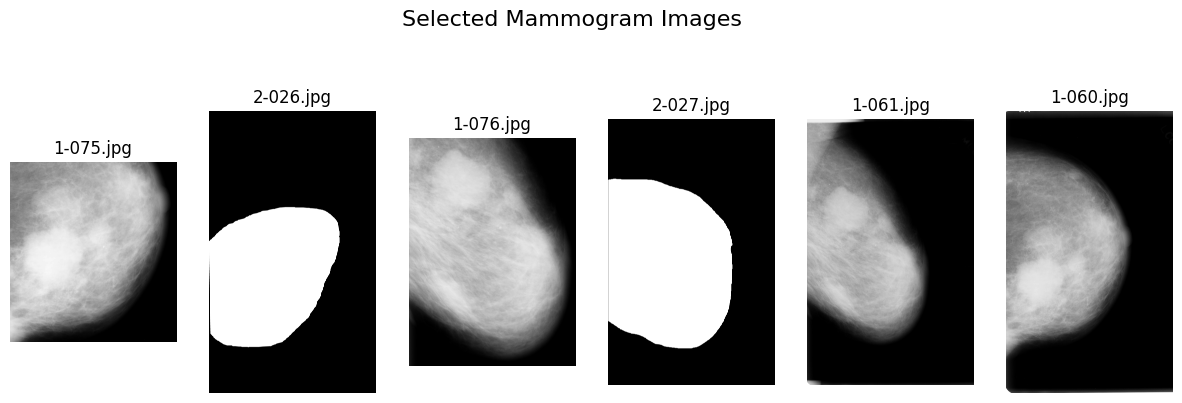

In [15]:
import matplotlib.pyplot as plt
from skimage.io import imread

image_paths = p_patient.new_image_path
print(image_paths)

# Set up the plot
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
fig.suptitle('Selected Mammogram Images', fontsize=16)

# Load and display each image
for ax, img_path in zip(axes, image_paths):
    img = imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1])

plt.show()

**Area:**
The number of pixels in the region. Description: This measures the total size of the region or object in pixels. For example, a tumor's area would be the total number of pixels that make up the tumor in the mask image.

**Perimeter:**
The total length of the boundary of the region. Description: This measures the length of the contour or edge of the region. It’s useful for understanding the shape complexity of the object. In the case of a tumor, it would give an idea of how "jagged" or smooth the boundary of the tumor is.

**Eccentricity:**
A measure of the extent to which the shape of the region deviates from being a perfect circle. Description: The eccentricity is calculated as the ratio of the distance between the foci of the ellipse to the length of its major axis. It ranges from 0 (for a perfect circle) to 1 (for a line segment). It helps in understanding how elongated the object is.

**Solidity:**
The ratio of the area of the region to the area of its convex hull. Description: Solidity measures how solid or filled the object is. A solidity of 1 indicates that the region is completely solid with no holes. Lower values suggest that the region has a more complex shape with holes or concavities.

**Extent:**
The ratio of the area of the region to the area of the bounding box. Description: Extent measures the proportion of the bounding box area that is occupied by the region. It ranges from 0 to 1, where 1 indicates that the region completely fills the bounding box. It helps understand how compact the object is within its bounding box.

In [11]:
import cv2
import numpy as np
import pandas as pd
import math
from skimage.measure import label, regionprops

image_files = ROI_images
rows = []

for i, file_path in enumerate(image_files):
    if i % 500 == 0:
        print(f"Processing image {i}: {file_path}")
    
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    binary_image = (image > 128).astype(np.uint8)
    
    # Area
    area = len(binary_image[binary_image > 0])
    
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Perimeter
    perimeter = cv2.arcLength(largest_contour, True)

    # Minor & major axis
    if len(largest_contour) >= 5:  # fitEllipse requires min 5 points
        ellipse = cv2.fitEllipse(largest_contour)
        (x, y), (major_axis, minor_axis), angle = ellipse
        longest_axis = max(major_axis, minor_axis)            
        shortest_axis = min(major_axis, minor_axis)
    else:
        longest_axis = shortest_axis = np.nan  # Not enough points to fit an ellipse
        
    # Eccentricity
    eccentricity = np.sqrt(1 - (((shortest_axis/2) / (longest_axis/2))**2))
        
    # Aspect Ratio
    if shortest_axis > 0:
        aspect_ratio = longest_axis / shortest_axis
    else:
        aspect_ratio = np.nan  # Avoid division by zero

    # Convex Hull
    hull = cv2.convexHull(largest_contour)
    convex_hull_area = cv2.contourArea(hull)
    convex_hull_perimeter = cv2.arcLength(hull, True)

    # Solidity
    if convex_hull_area > 0:
        solidity = area / convex_hull_area
    else:
        solidity = np.nan  # Avoid division by zero
        
        
    # Circularity
    if perimeter > 0:
        circularity = 4 * math.pi * (area / (convex_hull_perimeter ** 2))
    else:
        circularity = np.nan  # Avoid division by zero
        
        
    # Compactness
    compactness = perimeter**2 / (4 * math.pi * area)
                  

    # Jaggedness: Ratio of actual perimeter to smoothed perimeter
    epsilon = 0.01 * perimeter
    smoothed_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
    smoothed_perimeter = cv2.arcLength(smoothed_contour, True)
    if smoothed_perimeter > 0:
        jaggedness = perimeter / smoothed_perimeter
    else:
        jaggedness = np.nan  # Avoid division by zero

    # Store the results in a dictionary
    row = {
        'File': file_path,
        'Area': area,
        'Perimeter': perimeter,
        'Longest Axis': longest_axis,
        'Shortest Axis': shortest_axis,
        'Circularity': circularity,
        'Eccentricity': eccentricity,
        'Aspect Ratio': aspect_ratio,
        'Convex Hull Area': convex_hull_area,
        'Solidity': solidity,
        'Compactness': compactness,
        'Jaggedness': jaggedness
    }
    rows.append(row)

# Convert the rows to a DataFrame
df = pd.DataFrame(rows)

Processing image 0: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg
Processing image 500: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.317315352613325952126528562173476091576/2-090.jpg
Processing image 1000: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.338146621710515808723481844541194721981/2-139.jpg
Processing image 1500: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.134028147111418473700565628762023340112/2-027.jpg
Processing image 2000: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.424729954711159697125126701203315814592/1-014.jpg
Processing image 2500: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16879424211887678632529555554160231751/1-068.jpg
Processing image 3000: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/

In [12]:
df.describe()

,Area,Perimeter,Longest Axis,Shortest Axis,Circularity,Eccentricity,Aspect Ratio,Convex Hull Area,Solidity,Compactness,Jaggedness
count,3.247000e+03,3247.000000,3247.000000,3247.000000,3247.000000,3247.000000,3247.000000,3.247000e+03,3247.000000,3247.000000,3247.000000
mean,1.447114e+05,1697.897819,425.016989,296.392706,0.811457,0.606782,1.438087,1.608768e+05,0.900081,2.894270,1.328033
std,3.931890e+05,1273.966601,409.890242,242.930616,0.125830,0.173998,0.697657,4.110871e+05,0.090210,1.814265,0.266001
min,1.017000e+03,118.627417,35.990875,32.085304,0.078521,0.059071,1.001749,9.600000e+02,0.163548,1.073371,1.000000
25%,2.774700e+04,885.205186,218.840706,164.684456,0.766605,0.487518,1.145327,3.097700e+04,0.851927,1.361278,1.076157
50%,5.698100e+04,1419.851936,310.866394,241.080063,0.831359,0.603407,1.254024,6.439050e+04,0.911441,2.500885,1.280246
75%,1.171410e+05,2087.935196,456.268814,348.704514,0.892397,0.726951,1.456262,1.298698e+05,0.972827,4.006028,1.555182
max,8.876129e+06,11720.279012,5387.432617,3592.091797,0.988083,0.997057,13.044484,8.926682e+06,1.059375,19.892491,2.691573


In [13]:
# Save the DataFrame to a CSV file (optional)
df.to_csv('/kaggle/working/tumor_all_features_new.csv', index=False)

In [14]:
import cv2
import matplotlib.pyplot as plt

def present_image(image_path):
  image = cv2.imread(image_path)

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Display the image using Matplotlib
  plt.imshow(image_rgb)
  plt.axis('off')  # Hide axis
  plt.show()

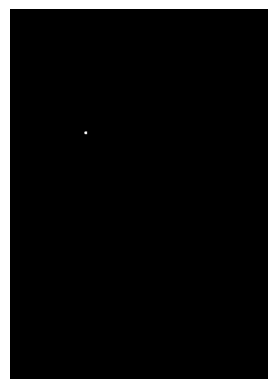

In [16]:
present_image(df.sort_values(by='Eccentricity')['File'].iloc[0])

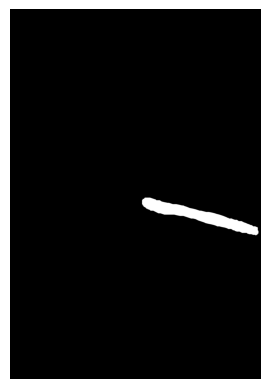

In [21]:
present_image(df.sort_values(by='Eccentricity')['File'].iloc[3246])

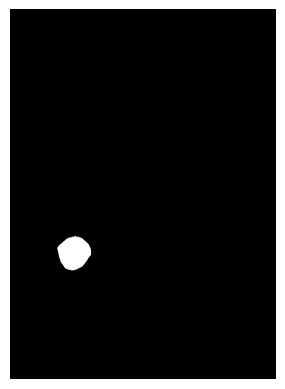

In [25]:
present_image(df.sort_values(by='Jaggedness')['File'].iloc[1500])

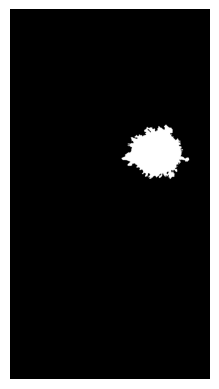

In [24]:
present_image(df.sort_values(by='Jaggedness')['File'].iloc[3246])

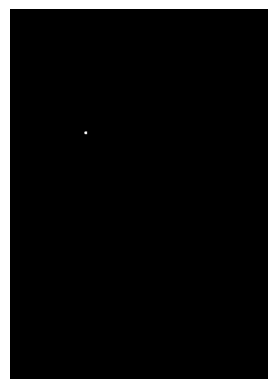

In [26]:
present_image(df.sort_values(by='Area')['File'].iloc[0])

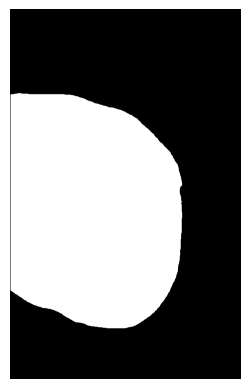

In [27]:
present_image(df.sort_values(by='Area')['File'].iloc[3246])

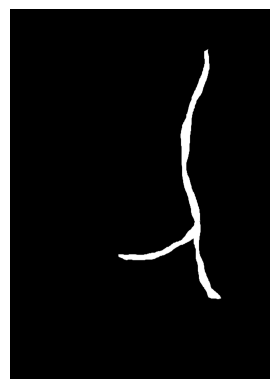

In [28]:
present_image(df.sort_values(by='Circularity')['File'].iloc[0])

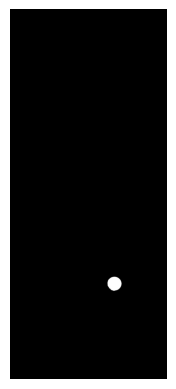

In [29]:
present_image(df.sort_values(by='Circularity')['File'].iloc[3246])